## Data Preprocess

<big>Cifar-100 由50000筆training data與10000筆testing data煮成的,共有20組class,與100種label

<big>處理Cifar-100,先處理Pickle檔用unpickle這個function,接著再用get_cifar100讀進來的reshape成(50000, 3, 32, 32)，首先(50000,3072)分成50000份，也就是1行1份，然後每份在分成3份，也就是R、G、B通道各一份，然後再將這一份分為32x32表示。下圖例子以(10000, 3, 32, 32)作為樣本，藍色圓圈內為相對應的某維度/軸。

![title](img/1.jpg)

<big>而(50000, 3, 32, 32).transpose(0,2,3,1)函數的意義則是生成矩陣進行轉置，新矩陣的0，1，2，3維度/軸分別為原矩陣的0，2，3，1維度/軸，從下面的圖中我們就可以清楚看到矩陣維度/軸的變換(50000, 3, 32, 32)===>(50000, 32, 32, 3)。


![title](img/2.jpg)

<small>最終回傳的形式為training data,training label,testing data,testing label,cifar-100 classes,cifar-100 classes 100 label

In [1]:
import os
import _pickle as cPickle
import numpy as np
def unpickle(file):
    fo = open(file, 'rb')
    dict = cPickle.load(fo, encoding='latin1')
    fo.close()
    return dict


def get_cifar100(folder):
    train_fname = os.path.join(folder,'train')
    test_fname  = os.path.join(folder,'test')
    data_dict = unpickle(train_fname)

    train_data = data_dict['data']
    train_data = train_data.reshape(train_data.shape[0],3,32,32).transpose([0, 2, 3, 1])
    print(train_data.shape)
    train_fine_labels = data_dict['fine_labels']
    train_coarse_labels = data_dict['coarse_labels']

    data_dict = unpickle(test_fname)
    test_data = data_dict['data']
    test_data = test_data.reshape(test_data.shape[0],3,32,32).transpose([0, 2, 3, 1])
    test_fine_labels = data_dict['fine_labels']
    test_coarse_labels = data_dict['coarse_labels']

    bm = unpickle(os.path.join(folder, 'meta'))
    clabel_names = bm['coarse_label_names']
    flabel_names = bm['fine_label_names']
    flabel_names100 = np.load("flabel_names.npy")

    return train_data, np.array(train_coarse_labels), np.array(train_fine_labels), test_data, np.array(test_coarse_labels), np.array(test_fine_labels), clabel_names, flabel_names100

<big>使用Pre-train model所以training sample不用太多,主要做fine-tuning,我們training set拿5000筆.由tensorflow作為backend的resnet50 input為(color_type,img_rows,img_cols) = (224,224,3)


In [2]:
import cv2
import numpy as np

from keras import backend as K
from keras.utils import np_utils

nb_train_samples = 5000 # 3000 training samples
nb_valid_samples = 1000 # 1000 validation samples
num_classes = 100

def load_cifar100_data(img_rows, img_cols):
    datapath2 = "./"
    # Load cifar10 training and validation sets
    tr_data100, tr_clabels100, tr_flabels100, te_data100, te_clabels100, te_flabels100, clabel_names100, flabel_names100 = get_cifar100(datapath2)
    # Resize trainging images
    if K.image_dim_ordering() == 'th':
        X_train = np.array([cv2.resize(img.transpose(1,2,0), (img_rows,img_cols)).transpose(2,0,1) for img in tr_data100[:nb_train_samples,:,:,:]])
        X_valid_1 = np.array([cv2.resize(img.transpose(1,2,0), (img_rows,img_cols)).transpose(2,0,1) for img in te_data100[5000:5000+nb_valid_samples,:,:,:]])
        X_test = np.array([cv2.resize(img.transpose(1,2,0), (img_rows,img_cols)).transpose(2,0,1) for img in te_data100[5000:5000+nb_valid_samples,:,:,:]])
    else:
        X_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in tr_data100[:nb_train_samples,:,:,:]])
        print(X_train.shape)
        X_valid_1 = np.array([cv2.resize(img, (img_rows,img_cols)) for img in te_data100[5000:5000+nb_valid_samples,:,:,:]])
        X_test = np.array([cv2.resize(img, (img_rows,img_cols)) for img in te_data100[5000:5000+nb_valid_samples,:,:,:]])


    # Transform targets to keras compatible format
    Y_train = np_utils.to_categorical(tr_flabels100[:nb_train_samples], num_classes)
    Y_valid_1 = np_utils.to_categorical(te_flabels100[5000:5000+nb_valid_samples], num_classes)
    Y_test = np_utils.to_categorical(te_flabels100[5000:5000+nb_valid_samples], num_classes)

    return X_train, Y_train, X_valid_1, Y_valid_1 ,X_test ,Y_test

Using TensorFlow backend.


<big> load Glove pre-train model

In [3]:
# -*- coding: utf-8 -*-
"""
word2vec embeddings start with a line with the number of lines (tokens?) and 
the number of dimensions of the file. This allows gensim to allocate memory 
accordingly for querying the model. Larger dimensions mean larger memory is 
held captive. Accordingly, this line has to be inserted into the GloVe 
embeddings file.
"""

import os
import shutil
from sys import platform
from gensim.models.keyedvectors import KeyedVectors

import gensim


def prepend_line(infile, outfile, line):
	""" 
	Function use to prepend lines using bash utilities in Linux. 
	(source: http://stackoverflow.com/a/10850588/610569)
	"""
	with open(infile, 'r', encoding = 'utf8') as old:
		with open(outfile, 'w', encoding = 'utf8') as new:
			new.write(str(line) + "\n")
			shutil.copyfileobj(old, new)

def prepend_slow(infile, outfile, line):
	"""
	Slower way to prepend the line by re-creating the inputfile.
	"""
	with open(infile, 'r', encoding = 'utf8') as fin:
		with open(outfile, 'w', encoding = 'utf8') as fout:
			fout.write(line + "\n")
			for line in fin:
				fout.write(line)

def get_lines(glove_file_name):
    """Return the number of vectors and dimensions in a file in GloVe format."""
    with open(glove_file_name, 'r', encoding = 'utf8' ) as f:
        num_lines = sum(1 for line in f)
    with open(glove_file_name, 'r', encoding = 'utf8' ) as f:
        num_dims = len(f.readline().split()) - 1
    return num_lines, num_dims
	
# Input: GloVe Model File
# More models can be downloaded from http://nlp.stanford.edu/projects/glove/
glove_file="glove.6B.300d.txt"

num_lines, dims = get_lines(glove_file)

# Output: Gensim Model text format.
gensim_file='glove_model300.txt'
gensim_first_line = "{} {}".format(num_lines, dims)

# Prepends the line.
if platform == "linux" or platform == "linux2":
	prepend_line(glove_file, gensim_file, gensim_first_line)
else:
	prepend_slow(glove_file, gensim_file, gensim_first_line)

# Demo: Loads the newly created glove_model.txt into gensim API.
w2model = gensim.models.KeyedVectors.load_word2vec_format(gensim_file,binary=False) #GloVe Model

C:\Users\WoChien\AppData\Local\Continuum\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


<big>找出word embedding沒有的cifar100 label,並更改為word embedding的word vector, 確保兩個是一致的, 如結果所示idx是空的, 所以是一致的。

In [4]:
tr_data100, tr_clabels100, tr_flabels100, te_data100, te_clabels100, te_flabels100, clabel_names100, flabel_names100 = get_cifar100("./")
print("cifar 100 label (changed)",flabel_names100)
idx = []
for label in flabel_names100:
    try:
        w2model[label]
    except:
        idx.append(flabel_names100.index(label))
print(idx)


(50000, 32, 32, 3)
cifar 100 label (changed) ['apple' 'aquarium' 'baby' 'bear' 'beaver' 'bed' 'bee' 'beetle' 'bicycle'
 'bottle' 'bowl' 'boy' 'bridge' 'bus' 'butterfly' 'camel' 'can' 'castle'
 'caterpillar' 'cattle' 'chair' 'chimpanzee' 'clock' 'cloud' 'cockroach'
 'couch' 'crab' 'crocodile' 'cup' 'dinosaur' 'dolphin' 'elephant'
 'flatfish' 'forest' 'fox' 'girl' 'hamster' 'house' 'kangaroo' 'keyboard'
 'lamp' 'mower' 'leopard' 'lion' 'lizard' 'lobster' 'man' 'maple'
 'motorcycle' 'mountain' 'mouse' 'mushroom' 'oaktree' 'orange' 'orchid'
 'otter' 'palm' 'pear' 'pickup' 'pine' 'plain' 'plate' 'poppy' 'porcupine'
 'possum' 'rabbit' 'raccoon' 'ray' 'road' 'rocket' 'rose' 'sea' 'seal'
 'shark' 'shrew' 'skunk' 'skyscraper' 'snail' 'snake' 'spider' 'squirrel'
 'streetcar' 'sunflower' 'pepper' 'table' 'tank' 'telephone' 'television'
 'tiger' 'tractor' 'train' 'trout' 'tulip' 'turtle' 'wardrobe' 'whale'
 'willow' 'wolf' 'woman' 'worm']
[]


In [5]:
tr_data100, tr_clabels100, tr_flabels100, te_data100, te_clabels100, te_flabels100, clabel_names100, flabel_names100 = get_cifar100("./")
print(flabel_names100)

(50000, 32, 32, 3)
['apple' 'aquarium' 'baby' 'bear' 'beaver' 'bed' 'bee' 'beetle' 'bicycle'
 'bottle' 'bowl' 'boy' 'bridge' 'bus' 'butterfly' 'camel' 'can' 'castle'
 'caterpillar' 'cattle' 'chair' 'chimpanzee' 'clock' 'cloud' 'cockroach'
 'couch' 'crab' 'crocodile' 'cup' 'dinosaur' 'dolphin' 'elephant'
 'flatfish' 'forest' 'fox' 'girl' 'hamster' 'house' 'kangaroo' 'keyboard'
 'lamp' 'mower' 'leopard' 'lion' 'lizard' 'lobster' 'man' 'maple'
 'motorcycle' 'mountain' 'mouse' 'mushroom' 'oaktree' 'orange' 'orchid'
 'otter' 'palm' 'pear' 'pickup' 'pine' 'plain' 'plate' 'poppy' 'porcupine'
 'possum' 'rabbit' 'raccoon' 'ray' 'road' 'rocket' 'rose' 'sea' 'seal'
 'shark' 'shrew' 'skunk' 'skyscraper' 'snail' 'snake' 'spider' 'squirrel'
 'streetcar' 'sunflower' 'pepper' 'table' 'tank' 'telephone' 'television'
 'tiger' 'tractor' 'train' 'trout' 'tulip' 'turtle' 'wardrobe' 'whale'
 'willow' 'wolf' 'woman' 'worm']


<big> 處理label2vector, 並把它存成label_vector.npy

In [5]:
#label_vector = []
label_vector = np.zeros(shape=(16,100,300))
for i in range(16):
    for word in flabel_names100:
        label_vector[i] = w2model[word]
np.save('./label_vector',label_vector)
label_vec = np.load('./label_vector.npy')
print(label_vector.shape)

(16, 100, 300)


## Plot Image
<big>測試顯示圖片

(50000, 32, 32, 3)
(5000, 224, 224, 3)


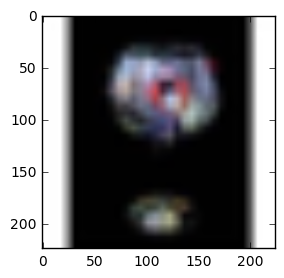

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from six.moves import cPickle
X_train, Y_train, X_valid_1, Y_valid_1 ,X_test ,Y_test = load_cifar100_data(224,224)

# Visualizing CIFAR 10
fig, axes1 = plt.subplots(1,1,figsize=(3,3))
for j in range(1):
    for k in range(1):
        i = np.random.choice(range(len(X_train)))
        #axes1[j][k].set_axis_off()
        plt.imshow(X_train[i:i+1][0])

## Model
<BIG>採用Keras的resnet model, pre-train model是參加image-net舉辦的比賽, 另外額外增加Data Augmentation, 將圖片水平翻轉, 並旋轉30度......etc, 避免fine-tuning之後太overfitting.

In [7]:
# -*- coding: utf-8 -*-

from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import backend as K
from keras.callbacks import CSVLogger
from sklearn.metrics import log_loss
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator


def identity_block(input_tensor, kernel_size, filters, stage, block):
    """
    The identity_block is the block that has no conv layer at shortcut
    Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    """

    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Convolution2D(nb_filter1, 1, 1, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter2, kernel_size, kernel_size,
                      border_mode='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter3, 1, 1, name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = merge([x, input_tensor], mode='sum')
    x = Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """
    conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    Note that from stage 3, the first conv layer at main path is with subsample=(2,2)
    And the shortcut should have subsample=(2,2) as well
    """

    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Convolution2D(nb_filter1, 1, 1, subsample=strides,
                      name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter2, kernel_size, kernel_size, border_mode='same',
                      name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter3, 1, 1, name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Convolution2D(nb_filter3, 1, 1, subsample=strides,
                             name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = merge([x, shortcut], mode='sum')
    x = Activation('relu')(x)
    return x

def resnet50_model(img_rows, img_cols, color_type=1, num_classes=None):
    """
    Resnet 50 Model for Keras
    Model Schema is based on 
    https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py
    ImageNet Pretrained Weights 
    https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_th_dim_ordering_th_kernels.h5
    Parameters:
      img_rows, img_cols - resolution of inputs
      channel - 1 for grayscale, 3 for color 
      num_classes - number of class labels for our classification task
    """

    # Handle Dimension Ordering for different backends
    global bn_axis
    if K.image_dim_ordering() == 'tf':
        bn_axis = 3
        img_input = Input(shape=(img_rows, img_cols, color_type))
    else:
        bn_axis = 1
        img_input = Input(shape=(color_type, img_rows, img_cols))

    x = ZeroPadding2D((3, 3))(img_input)
    x = Convolution2D(64, 7, 7, subsample=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    # Fully Connected Softmax Layer
    x_fc = AveragePooling2D((7, 7), name='avg_pool')(x)
    x_fc = Flatten()(x_fc)
    x_fc = Dense(1000, activation='softmax', name='fc1000')(x_fc)

    # Create model
    model = Model(img_input, x_fc)

    # Load ImageNet pre-trained data 
    if K.image_dim_ordering() == 'th':
      # Use pre-trained weights for Theano backend
      weights_path = 'imagenet_models/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
    else:
      # Use pre-trained weights for Tensorflow backend
      weights_path = 'imagenet_models/resnet50_weights_tf_dim_ordering_tf_kernels.h5'

    model.load_weights(weights_path)

    # Truncate and replace softmax layer for transfer learning
    # Cannot use model.layers.pop() since model is not of Sequential() type
    # The method below works since pre-trained weights are stored in layers but not in the model
    x_newfc = AveragePooling2D((7, 7), name='avg_pool')(x)
    x_newfc = Flatten()(x_newfc)
    x_newfc = Dense(num_classes, activation='softmax', name='fc10')(x_newfc)

    # Create another model with our customized softmax
    model = Model(img_input, x_newfc)

    # Learning rate is changed to 0.001
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
  
    return model

# Example to fine-tune on 5000 samples from Cifar10

img_rows, img_cols = 224, 224 # Resolution of inputs
channel = 3
num_classes = 100
batch_size = 16 
nb_epoch = 20

X_train, Y_train, X_valid_1, Y_valid_1 ,X_test ,Y_test = load_cifar100_data(img_rows,img_cols)
datagen = ImageDataGenerator(
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")
datagen.fit(X_train)

(50000, 32, 32, 3)
(5000, 224, 224, 3)


## Training

<big> 圖片餵進去的形式為(224,224,3), 儲存log已方便觀測, epoch之於accuracy的變化, validation set 用後1000筆

In [8]:

# Load our model
model = resnet50_model(img_rows, img_cols, channel, num_classes)
if os.path.exists('./model_no_cotrain.h5'):
    model.load_weights('./model_no_cotrain.h5')
callbacks_list = []
csv_logger = CSVLogger('log_cifar100.csv', append=True, separator=';')
callbacks_list.append(csv_logger)
checkpoint = ModelCheckpoint('./model_no_cotrain.h5', monitor='val_acc', verbose=0, save_best_only=True, mode='max', period=1)
callbacks_list.append(checkpoint)

# Start Fine-tuning
model.fit(X_train, Y_train,
      batch_size=batch_size,
      nb_epoch=nb_epoch,
      shuffle=True,
      verbose=1,
      validation_data=(X_valid_1, Y_valid_1),
      callbacks=callbacks_list
      )

# Make predictions
predictions_valid = model.predict(X_test, batch_size=batch_size, verbose=1)

# Cross-entropy loss score


C:\Users\WoChien\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:107: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (7, 7), name="conv1", strides=(2, 2))`
C:\Users\WoChien\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:64: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), name="res2a_branch2a", strides=(1, 1))`
C:\Users\WoChien\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:69: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), name="res2a_branch2b", padding="same")`
C:\Users\WoChien\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:73: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 1), name="res2a_branch2c")`
C:\Users\WoChien\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:77: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, 

Train on 5000 samples, validate on 1000 samples
Epoch 1/20
5000/5000 [==============================] - 249s 50ms/step - loss: 3.6131 - acc: 0.1878 - val_loss: 2.5487 - val_acc: 0.3540
Epoch 2/20
5000/5000 [==============================] - 235s 47ms/step - loss: 1.7169 - acc: 0.5456 - val_loss: 1.9173 - val_acc: 0.4870
Epoch 3/20
5000/5000 [==============================] - 236s 47ms/step - loss: 0.8380 - acc: 0.7936 - val_loss: 1.5550 - val_acc: 0.5700
Epoch 4/20
5000/5000 [==============================] - 237s 47ms/step - loss: 0.3854 - acc: 0.9258 - val_loss: 1.4430 - val_acc: 0.5840
Epoch 5/20
5000/5000 [==============================] - 240s 48ms/step - loss: 0.1873 - acc: 0.9766 - val_loss: 1.3921 - val_acc: 0.6060
Epoch 6/20
5000/5000 [==============================] - 240s 48ms/step - loss: 0.0944 - acc: 0.9920 - val_loss: 1.3053 - val_acc: 0.6440
Epoch 7/20
5000/5000 [==============================] - 238s 48ms/step - loss: 0.0628 - acc: 0.9966 - val_loss: 1.3262 - val_acc: 

## Predict Data

<big> 此無用, 是為了保留程式碼完整性, 這是用來test cifar100.

In [9]:
from sklearn.metrics import accuracy_score
channel = 3
num_classes = 100
batch_size = 16 
img_rows, img_cols = 224, 224 # Resolution of inputs

# load
from keras.models import load_model
from sklearn.metrics import log_loss

model = load_model('./model_no_cotrain.h5')
predictions_test = model.predict(X_test, batch_size=batch_size, verbose=1)
score = log_loss(Y_test, predictions_test)

Y_pred = []
for preds in predictions_test:
    order = sorted(range(len(preds)), key=lambda k: preds[k])[::-1]
    Y_pred.append(order[0])
print(Y_pred)
new_data = np.zeros(Y_test.shape[0])
for i in range(Y_test.shape[0]):
    for j in range(Y_test.shape[1]):
        if Y_test[i,j] == 1:
            new_data[i] = j

print("accuracy: ",accuracy_score(new_data,Y_pred))
print("score: ",score)

C:\Users\WoChien\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\engine\topology.py:1253: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


1000/1000 [==============================] - 16s 16ms/step
[56, 53, 82, 48, 76, 82, 60, 20, 58, 58, 40, 37, 66, 74, 68, 90, 97, 35, 68, 47, 89, 91, 53, 23, 29, 89, 35, 43, 62, 15, 9, 27, 73, 44, 75, 20, 33, 41, 79, 71, 55, 17, 76, 78, 88, 49, 11, 54, 86, 33, 4, 80, 33, 49, 60, 63, 78, 48, 36, 37, 66, 35, 76, 8, 13, 53, 87, 19, 40, 1, 32, 88, 63, 78, 99, 75, 21, 63, 97, 75, 36, 52, 94, 10, 34, 14, 63, 10, 1, 80, 21, 81, 98, 69, 96, 26, 20, 91, 68, 64, 76, 5, 9, 31, 49, 10, 77, 32, 83, 42, 58, 44, 48, 15, 48, 17, 16, 35, 98, 15, 21, 90, 59, 14, 37, 88, 11, 10, 19, 58, 90, 43, 3, 32, 23, 28, 68, 80, 39, 87, 25, 89, 42, 74, 91, 47, 20, 22, 6, 58, 44, 61, 91, 71, 74, 82, 66, 30, 47, 34, 57, 54, 48, 81, 85, 15, 5, 21, 26, 25, 51, 8, 28, 44, 35, 48, 13, 36, 32, 86, 19, 33, 90, 35, 81, 42, 60, 69, 68, 89, 50, 24, 49, 12, 71, 5, 71, 46, 7, 88, 27, 13, 25, 11, 44, 17, 18, 74, 19, 18, 42, 57, 60, 95, 57, 84, 48, 75, 19, 51, 73, 93, 41, 52, 52, 12, 64, 87, 99, 86, 94, 42, 71, 64, 99, 59, 22, 96, 4

## Plot relation image

<big> 隨機挑選一張圖片, 排序預測出來的label, 顯示圖片, 並畫出直方圖

[31, 38, 15, 34, 3, 19, 29, 96, 97, 30, 25, 44, 55, 20, 7, 27, 43, 72, 2, 65, 80, 59, 74, 4, 95, 18, 11, 24, 46, 52, 26, 64, 99, 54, 91, 57, 77, 8, 66, 51, 6, 45, 92, 84, 73, 14, 21, 42, 41, 79, 93, 68, 39, 63, 67, 49, 98, 48, 85, 56, 12, 33, 75, 36, 23, 13, 62, 71, 40, 5, 87, 88, 37, 22, 82, 32, 1, 47, 83, 9, 0, 16, 58, 78, 35, 28, 86, 89, 76, 17, 50, 69, 10, 61, 94, 90, 60, 70, 53, 81]
[0.62657893, 0.10305034, 0.081758246, 0.051033523, 0.041912511, 0.0343167, 0.014780333, 0.0071505234, 0.0051074615, 0.0047976091, 0.004693226, 0.0027751869, 0.0027461504, 0.0019704243, 0.0015260086, 0.0014795, 0.0011933158, 0.0011528798, 0.0011137369, 0.0010353921, 0.00088279706, 0.00050025329, 0.00049251987, 0.00047044936, 0.00046756462, 0.00046477272, 0.00044222877, 0.00037677662, 0.00030508343, 0.00030000316, 0.00026296376, 0.00024687249, 0.00024552326, 0.00023790884, 0.00019191441, 0.00018934923, 0.00018388657, 0.00017087968, 0.00016316029, 0.00015214813, 0.00014885952, 0.00013906894, 0.00012862413

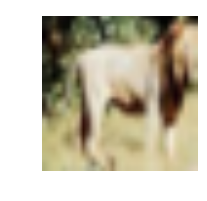

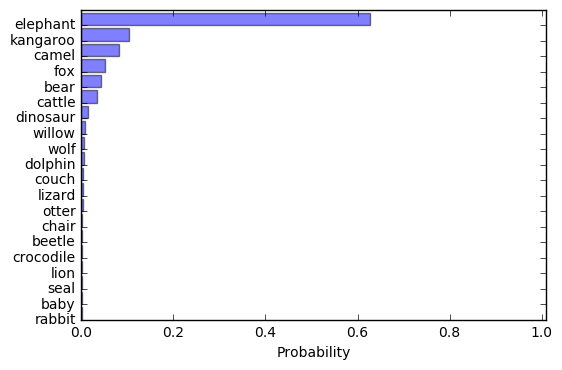

In [10]:
import matplotlib.pyplot as plt
def plot_preds(image, preds):
    """Displays image and the top-n predicted probabilities in a bar graph
    Args:
    image: PIL image
    preds: list of predicted labels and their probabilities
    """
    CIFAR10_LABELS_LIST = flabel_names100
    label_order = []
    
    fig, axes1 = plt.subplots(1,1,figsize=(2,2))
    for j in range(1):
        for k in range(1):
            i = np.random.choice(range(len(image)))
            #axes1[j][k].set_axis_off()
            plt.imshow(image)
            
    #plt.imshow(image)
    plt.axis('off')
    plt.figure()

    order = sorted(range(len(preds)), key=lambda k: preds[k])[::-1]
    print(order)
    bar_preds = sorted(preds)[::-1]
    print(bar_preds)
    for i in range(len(order)):
        label_order.append(CIFAR10_LABELS_LIST[order[i]])
    print(label_order)
    plt.barh(np.arange(20)[::-1], bar_preds[:20], alpha=0.5)
    plt.yticks(np.arange(20)[::-1], label_order[:20])
    plt.xlabel('Probability')
    plt.xlim(0,1.01)
    plt.show()
    
# print(predictions_valid[0])
plot_preds(X_test[103],predictions_test[103])

(50000, 32, 32, 3)
(50000, 32, 32, 3)
(32, 32, 3)
(50000, 32, 32, 3)


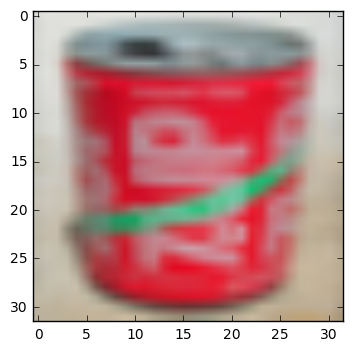

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from six.moves import cPickle
datapath2 = "./"
# Load cifar10 training and validation sets
tr_data100, tr_clabels100, tr_flabels100, te_data100, te_clabels100, te_flabels100, clabel_names100, flabel_names100 = get_cifar100(datapath2)
X = tr_data100
print(X.shape)
# Y = np.array(Y)
# Visualizing CIFAR 10

i = np.random.choice(range(len(X)))
plt.imshow(X[i:i+1][0])
print(X[i:i+1][0].shape)
print(tr_data100.shape)

## Word2Vec

<big> 如上, 請勿重複執行, 因為跑很久

In [10]:
# -*- coding: utf-8 -*-
"""
word2vec embeddings start with a line with the number of lines (tokens?) and 
the number of dimensions of the file. This allows gensim to allocate memory 
accordingly for querying the model. Larger dimensions mean larger memory is 
held captive. Accordingly, this line has to be inserted into the GloVe 
embeddings file.
"""

import os
import shutil
from sys import platform
from gensim.models.keyedvectors import KeyedVectors
import gensim


def prepend_line(infile, outfile, line):
	""" 
	Function use to prepend lines using bash utilities in Linux. 
	(source: http://stackoverflow.com/a/10850588/610569)
	"""
	with open(infile, 'r', encoding = 'utf8') as old:
		with open(outfile, 'w', encoding = 'utf8') as new:
			new.write(str(line) + "\n")
			shutil.copyfileobj(old, new)

def prepend_slow(infile, outfile, line):
	"""
	Slower way to prepend the line by re-creating the inputfile.
	"""
	with open(infile, 'r', encoding = 'utf8') as fin:
		with open(outfile, 'w', encoding = 'utf8') as fout:
			fout.write(line + "\n")
			for line in fin:
				fout.write(line)

def get_lines(glove_file_name):
    """Return the number of vectors and dimensions in a file in GloVe format."""
    with open(glove_file_name, 'r', encoding = 'utf8' ) as f:
        num_lines = sum(1 for line in f)
    with open(glove_file_name, 'r', encoding = 'utf8' ) as f:
        num_dims = len(f.readline().split()) - 1
    return num_lines, num_dims
	
# Input: GloVe Model File
# More models can be downloaded from http://nlp.stanford.edu/projects/glove/
glove_file="glove.6B.300d.txt"

num_lines, dims = get_lines(glove_file)

# Output: Gensim Model text format.
gensim_file='glove_model300.txt'
gensim_first_line = "{} {}".format(num_lines, dims)

# Prepends the line.
if platform == "linux" or platform == "linux2":
	prepend_line(glove_file, gensim_file, gensim_first_line)
else:
	prepend_slow(glove_file, gensim_file, gensim_first_line)

# Demo: Loads the newly created glove_model.txt into gensim API.
w2model = gensim.models.KeyedVectors.load_word2vec_format(gensim_file,binary=False) #GloVe Model

C:\Users\WoChien\AppData\Local\Continuum\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


<big> 單純測試word2vec是否正常

In [8]:
y2 = w2model.most_similar("apple", topn=20)
for item in y2:
    print (item[0], item[1])

iphone 0.5987042188644409
macintosh 0.5836331248283386
ipod 0.5761123895645142
microsoft 0.5663833022117615
ipad 0.5628098249435425
intel 0.5457563400268555
ibm 0.5286195278167725
google 0.5282472372055054
imac 0.5072520971298218
software 0.4962984323501587
motorola 0.47161784768104553
computer 0.4711154103279114
apples 0.46574175357818604
itunes 0.4646926522254944
pc 0.4600933790206909
iphones 0.452551007270813
mac 0.4503524601459503
ipods 0.44740575551986694
cherry 0.4464744031429291
computers 0.44292744994163513


<big> 這邊沒使用到, 可跳過

In [8]:
def get_test(folder):
    train_fname = os.path.join(folder,'train')
    test_fname  = os.path.join(folder,'test')
    data_dict = unpickle(train_fname)

    train_data = data_dict['data']
    train_data = train_data.reshape(train_data.shape[0],3,32,32).transpose([0, 2, 3, 1])
    train_fine_labels = data_dict['fine_labels']
    train_coarse_labels = data_dict['coarse_labels']

    data_dict = unpickle(test_fname)
    test_data = data_dict['data']
    test_data = test_data.reshape(test_data.shape[0],3,32,32).transpose([0, 2, 3, 1])
    test_fine_labels = data_dict['fine_labels']
    test_coarse_labels = data_dict['coarse_labels']

    bm = unpickle(os.path.join(folder, 'meta'))
    clabel_names = bm['coarse_label_names']
    flabel_names = bm['fine_label_names']

    return train_data, np.array(train_coarse_labels), np.array(train_fine_labels), test_data, np.array(test_coarse_labels), np.array(test_fine_labels), clabel_names, flabel_names

def load_test_data(img_rows, img_cols):

    # Resize trainging images
    if K.image_dim_ordering() == 'th':
        X_train = np.array([cv2.resize(img.transpose(1,2,0), (img_rows,img_cols)).transpose(2,0,1) for img in tr_data100[:nb_train_samples,:,:,:]])
        X_valid_1 = np.array([cv2.resize(img.transpose(1,2,0), (img_rows,img_cols)).transpose(2,0,1) for img in te_data100[0:nb_valid_samples,:,:,:]])
        X_test = np.array([cv2.resize(img.transpose(1,2,0), (img_rows,img_cols)).transpose(2,0,1) for img in te_data100[nb_valid_samples:2000,:,:,:]])
    else:
        X_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in tr_data100[:nb_train_samples,:,:,:]])
        X_valid_1 = np.array([cv2.resize(img, (img_rows,img_cols)) for img in te_data100[0:nb_valid_samples,:,:,:]])
        X_test = np.array([cv2.resize(img, (img_rows,img_cols)) for img in te_data100[nb_valid_samples:2000,:,:,:]])


    # Transform targets to keras compatible format
    Y_train = np_utils.to_categorical(tr_flabels100[:nb_train_samples], num_classes)
    Y_valid_1 = np_utils.to_categorical(te_flabels100[0:nb_valid_samples], num_classes)
    Y_test = np_utils.to_categorical(te_flabels100[1000:2000], num_classes)

    return X_train, Y_train, X_valid_1, Y_valid_1 ,X_test ,Y_test

(3000, 100)
(3000, 224, 224, 3)


In [19]:
from PIL import Image
print(X_train.shape)
new_im = Image.fromarray(X_train[0])
new_im.show()


(3000, 224, 224, 3)


# Reshape unseen data

In [11]:
#!/usr/bin/env python
from PIL import Image
from glob import glob
from os.path import splitext

jpglist = glob( "test_img/*.[jJ][pP][gG]" )
jpg_array = []
for jpg in jpglist:
    im = Image.open(jpg)
    im = im.resize( (224, 224), Image.BILINEAR )
    data = np.asarray(im)
    data = data[np.newaxis,:,:,:]
    print(jpg.split('\\')[1],"...",data.shape)
    jpg_array.append(data)
    
new_jpg = np.concatenate((jpg_array[:]), axis=0)
print(new_jpg.shape)

01.dog.jpg ... (1, 224, 224, 3)
02.dog.jpg ... (1, 224, 224, 3)
03.pig.jpg ... (1, 224, 224, 3)
04.mango.jpg ... (1, 224, 224, 3)
05.pinapple.jpg ... (1, 224, 224, 3)
06.car.jpg ... (1, 224, 224, 3)
07.cat.jpg ... (1, 224, 224, 3)
08.sailfish.JPG ... (1, 224, 224, 3)
09.tyrannosaurus.jpg ... (1, 224, 224, 3)
10.seahorse.jpg ... (1, 224, 224, 3)
11.donkey.jpg ... (1, 224, 224, 3)
12.cherry.jpg ... (1, 224, 224, 3)
13.bucket.jpg ... (1, 224, 224, 3)
14.monkey.jpg ... (1, 224, 224, 3)
15.ant.jpg ... (1, 224, 224, 3)
16.mantis.jpg ... (1, 224, 224, 3)
17.polar.jpg ... (1, 224, 224, 3)
18.liger.jpg ... (1, 224, 224, 3)
19.rhino.jpg ... (1, 224, 224, 3)
20.coconut.jpg ... (1, 224, 224, 3)
21.homeback.jpg ... (1, 224, 224, 3)
22.piano.jpg ... (1, 224, 224, 3)
23.garlic.jpg ... (1, 224, 224, 3)
24.orangutan.jpg ... (1, 224, 224, 3)
25.sun.jpg ... (1, 224, 224, 3)
26.airplane.jpg ... (1, 224, 224, 3)
27.ipomoea.jpg ... (1, 224, 224, 3)
28.cow.jpg ... (1, 224, 224, 3)
29.banana.jpg ... (1, 224, 

# Zero-shot

<big> 從這裡開始就是實作zero-shot

In [12]:
from PIL import Image
from keras.models import load_model
from sklearn.metrics import log_loss

model = load_model('model_no_cotrain.h5')
predictions_test = model.predict(new_jpg, batch_size=batch_size, verbose=1)

Y_pred = []
for preds in predictions_test:
    order = sorted(range(len(preds)), key=lambda k: preds[k])[::-1]
    Y_pred.append(order[0])
print(len(Y_pred))


C:\Users\WoChien\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\engine\topology.py:1253: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


40/40 [==============================] - 2s 38ms/step
40


<big> 首先把預測由大至小的順序存起來

In [13]:
import matplotlib.pyplot as plt
def top_preds(preds, top=10):

    CIFAR10_LABELS_LIST = flabel_names100
    label_order = []

    order = sorted(range(len(preds)), key=lambda k: preds[k])[::-1]
    bar_preds = sorted(preds)[::-1]
    for i in range(len(order)):
        label_order.append(CIFAR10_LABELS_LIST[order[i]])
    return bar_preds[:top],label_order[:top]

top_list = []
order_list = []
for i in range(new_jpg.shape[0]):
    bar_preds, label_order = top_preds(predictions_test[i])
    top_list.append(bar_preds)
    order_list.append(label_order)

#print(top_list)
print(order_list[39])

['bee', 'cockroach', 'crab', 'caterpillar', 'beetle', 'dinosaur', 'lobster', 'spider', 'snake', 'bicycle']


<big>首先, top K個 機率 * 相對應預測的K 個在word embedding的vector, 接著求總和, 再除以這些機率相加起來, 之後將此向量餵進word embedding , 跟求cosine similarity.<big>
![title](img/3.jpg)
![title](img/4.jpg)
![title](img/5.jpg)


In [14]:
def convex_comb(top_list, order_list, top=5):

    result = np.zeros((len(top_list),300))
    for i in range(len(top_list)):
        Z = 0
        a = 0
        count = 0
        for j in range(top):
            Z += top_list[i][j]
            if count == 1:
                a += (top_list[i][j]+0.2) * w2model[order_list[i][j]]
                count += 1
                continue
            elif count == 2:
                a += (top_list[i][j]+0.2) * w2model[order_list[i][j]]
                count += 1
                continue
            elif count == 3:
                a += (top_list[i][j]+0.2) * w2model[order_list[i][j]]
                count += 1
                continue
            elif count == 4:
                a += (top_list[i][j]+0.2) * w2model[order_list[i][j]]
                count += 1
                continue
            elif count == 5:
                a += (top_list[i][j]+0.2) * w2model[order_list[i][j]]
                count += 1
                continue
            elif count == 6:
                a += (top_list[i][j]+0.2) * w2model[order_list[i][j]]
                count += 1
                continue
            elif count == 7:
                a += (top_list[i][j]+0.2) * w2model[order_list[i][j]]
                count += 1
                continue
            elif count == 8:
                a += (top_list[i][j]+0.2) * w2model[order_list[i][j]]
                count += 1
                continue
            elif count == 9:
                a += (top_list[i][j]+0.2) * w2model[order_list[i][j]]
                count += 1
                continue
            count += 1
            a += top_list[i][j] * w2model[order_list[i][j]]
        result[i] = a / Z
        
    return result

result = convex_comb(top_list, order_list, top=10)

#print(len(top_list))
#print(w2model.most_similar("cloud",topn=20))
print("Top 20:")
w2model.most_similar([result[1]],topn=21)


Top 20:


[('wolf', 0.8347303867340088),
 ('dog', 0.6101952791213989),
 ('deer', 0.606178879737854),
 ('rabbit', 0.5699571967124939),
 ('coyote', 0.5545734167098999),
 ('sheep', 0.5497735142707825),
 ('elk', 0.5482771396636963),
 ('bear', 0.5457806587219238),
 ('shark', 0.5439749956130981),
 ('squirrel', 0.5396045446395874),
 ('lion', 0.5338391661643982),
 ('cat', 0.5323343276977539),
 ('boar', 0.5271656513214111),
 ('raccoon', 0.5257347822189331),
 ('elephant', 0.5217580795288086),
 ('goat', 0.5207915902137756),
 ('snake', 0.5149386525154114),
 ('whale', 0.5138497948646545),
 ('rat', 0.5109356641769409),
 ('beaver', 0.5048168897628784),
 ('moose', 0.5020586252212524)]

In [15]:
w2model.most_similar('wolf',topn=21)

[('coyote', 0.47456061840057373),
 ('wolves', 0.460591197013855),
 ('bear', 0.45930150151252747),
 ('blitzer', 0.4558833837509155),
 ('dog', 0.4463757276535034),
 ('lion', 0.42983800172805786),
 ('deer', 0.4276125133037567),
 ('grizzly', 0.4270249009132385),
 ('reintroduction', 0.4230818748474121),
 ('elk', 0.4201168417930603),
 ('hunter', 0.4173934757709503),
 ('moose', 0.3994637429714203),
 ('cub', 0.39849019050598145),
 ('biermann', 0.3953385353088379),
 ('markus', 0.388600617647171),
 ('wild', 0.3843236267566681),
 ('fox', 0.38364139199256897),
 ('pack', 0.3794283866882324),
 ('bears', 0.379219114780426),
 ('beaver', 0.3770464062690735),
 ('bull', 0.37161147594451904)]

In [18]:
def comput_top_acc(result,jpglist,top=20):
    label = []
    hit_count = 0
    for ii,jpg in enumerate(jpglist):
        if jpg.split('\\')[1].split('.')[1] in roo[ii,:top]:
            hit_count += 1
            print(roo[ii,:top])
            print("Label:",jpg.split('\\')[1].split('.')[1])
    print("k=",top,"flat hit:",hit_count / len(jpglist))        
        
def remove_1thvec(result):
    rm_vec = np.zeros((len(result),20)).astype('U20')
    for i in range(len(result)):
        sim = w2model.most_similar([result[i]],topn=21)
        for ii,j in enumerate(sim):
            if ii == 0:
                continue
            rm_vec[i][ii-1] = j[0]
    return rm_vec

roo = remove_1thvec(result)
print(roo.shape)
print(len(result))
comput_top_acc(roo,jpglist)


(40, 20)
40
['lion' 'bear' 'dog' 'rabbit' 'deer' 'squirrel' 'cat' 'fox' 'elephant'
 'tiger' 'monkey' 'leopard' 'boar' 'coyote' 'rat' 'raccoon' 'shark' 'moose'
 'cats' 'beaver']
Label: dog
['dog' 'deer' 'rabbit' 'coyote' 'sheep' 'elk' 'bear' 'shark' 'squirrel'
 'lion' 'cat' 'boar' 'raccoon' 'elephant' 'goat' 'snake' 'whale' 'rat'
 'beaver' 'moose']
Label: dog
['squirrel' 'rabbits' 'monkey' 'deer' 'dog' 'goat' 'cat' 'rat' 'mouse'
 'rodent' 'frog' 'raccoon' 'boar' 'hamster' 'pig' 'possum' 'coyote'
 'squirrels' 'wolf' 'sheep']
Label: pig
['peach' 'lemon' 'fruit' 'citrus' 'juice' 'yellow' 'tomato' 'mango' 'apple'
 'lime' 'grapefruit' 'cream' 'honey' 'pink' 'colored' 'pear' 'pineapple'
 'cherry' 'onion' 'olive']
Label: mango
['truck' 'car' 'pickup' 'vehicle' 'cars' 'buses' 'taxi' 'bicycle' 'tractor'
 'vehicles' 'parked' 'jeep' 'trucks' 'cab' 'motorcycle' 'driver' 'suv'
 'passenger' 'bike' 'trolley']
Label: car
['tiger' 'elephant' 'wolf' 'cat' 'lion' 'deer' 'rabbit' 'shark' 'snake'
 'squirrel

In [17]:
for ii,jpg in enumerate(jpglist):
    if jpg.split('\\')[1].split('.')[1] in roo[ii]:
        print(jpg.split('\\')[1].split('.')[1])
        print(roo[ii],"hit")

dog
['lion' 'bear' 'dog' 'rabbit' 'deer' 'squirrel' 'cat' 'fox' 'elephant'
 'tiger' 'monkey' 'leopard' 'boar' 'coyote' 'rat' 'raccoon' 'shark' 'moose'
 'cats' 'beaver'] hit
dog
['dog' 'deer' 'rabbit' 'coyote' 'sheep' 'elk' 'bear' 'shark' 'squirrel'
 'lion' 'cat' 'boar' 'raccoon' 'elephant' 'goat' 'snake' 'whale' 'rat'
 'beaver' 'moose'] hit
pig
['squirrel' 'rabbits' 'monkey' 'deer' 'dog' 'goat' 'cat' 'rat' 'mouse'
 'rodent' 'frog' 'raccoon' 'boar' 'hamster' 'pig' 'possum' 'coyote'
 'squirrels' 'wolf' 'sheep'] hit
mango
['peach' 'lemon' 'fruit' 'citrus' 'juice' 'yellow' 'tomato' 'mango' 'apple'
 'lime' 'grapefruit' 'cream' 'honey' 'pink' 'colored' 'pear' 'pineapple'
 'cherry' 'onion' 'olive'] hit
car
['truck' 'car' 'pickup' 'vehicle' 'cars' 'buses' 'taxi' 'bicycle' 'tractor'
 'vehicles' 'parked' 'jeep' 'trucks' 'cab' 'motorcycle' 'driver' 'suv'
 'passenger' 'bike' 'trolley'] hit
cat
['tiger' 'elephant' 'wolf' 'cat' 'lion' 'deer' 'rabbit' 'shark' 'snake'
 'squirrel' 'dog' 'frog' 'rat' 'c

In [148]:
for i,pred in enumerate(Y_pred):
    print(i,". ",flabel_names100[pred])
    y2 = w2model.most_similar(flabel_names100[pred], topn=10)
    for item in y2:
        print (item[0], item[1])
    new_im = Image.fromarray(new_jpg[i])
    plt.figure()
    plt.imshow(new_im)
    


0 .  wolf
coyote 0.47456061840057373
wolves 0.460591197013855
bear 0.45930150151252747
blitzer 0.4558833837509155
dog 0.4463757276535034
lion 0.42983800172805786
deer 0.4276125133037567
grizzly 0.4270249009132385
reintroduction 0.4230818748474121
elk 0.4201168417930603
1 .  wolf
coyote 0.47456061840057373
wolves 0.460591197013855
bear 0.45930150151252747
blitzer 0.4558833837509155
dog 0.4463757276535034
lion 0.42983800172805786
deer 0.4276125133037567
grizzly 0.4270249009132385
reintroduction 0.4230818748474121
elk 0.4201168417930603
2 .  rocket
rockets 0.7361477613449097
launchers 0.6281849145889282
launch 0.6148226261138916
launcher 0.6134235858917236
missile 0.6004536151885986
launching 0.5770816802978516
mortar 0.574692964553833
missiles 0.5727017521858215
mortars 0.5546509623527527
katyusha 0.5427122712135315
3 .  keyboard
keyboards 0.7201798558235168
guitar 0.5928047895431519
synthesizer 0.589126706123352
qwerty 0.5800153017044067
piano 0.5522717237472534
keypad 0.528959035873413

C:\Users\WoChien\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


22 .  beetle
beetles 0.7699827551841736
moth 0.5433322191238403
insect 0.5118557214736938
moths 0.5105266571044922
infestation 0.5001180171966553
subfamily 0.48225530982017517
fungus 0.4747370779514313
species 0.4718002378940582
rodent 0.46745938062667847
genus 0.4581872820854187
23 .  keyboard
keyboards 0.7201798558235168
guitar 0.5928047895431519
synthesizer 0.589126706123352
qwerty 0.5800153017044067
piano 0.5522717237472534
keypad 0.5289590358734131
typewriter 0.5277976989746094
mouse 0.5248468518257141
typing 0.5127203464508057
cello 0.5089842677116394
24 .  pepper
garlic 0.6385728716850281
peppers 0.6183657646179199
chili 0.6119606494903564
onion 0.5958907008171082
cumin 0.5768879652023315
ginger 0.5757869482040405
teaspoon 0.5754161477088928
sauce 0.5721179246902466
lemon 0.5593305826187134
vinegar 0.5583981275558472
25 .  rocket
rockets 0.7361477613449097
launchers 0.6281849145889282
launch 0.6148226261138916
launcher 0.6134235858917236
missile 0.6004536151885986
launching 0.57

1 .  fox
abc 0.6516908407211304 nbc 0.6511223912239075 cbs 0.630840003490448 television 0.5419456958770752 cnn 0.5323412418365479 espn 0.5256397724151611 tv 0.5250257253646851 msnbc 0.5067328214645386 channel 0.4897475838661194 aired 0.48727792501449585 

2 .  possum
ringtail 0.5088215470314026 brushtail 0.48896127939224243 possums 0.4285174608230591 squirrel 0.3989391326904297 toad 0.3805606961250305 rabbit 0.3615792989730835 proverbial 0.3603993058204651 pygmy 0.3562662601470947 partridge 0.3509819507598877 raccoon 0.3492455780506134 

3 .  mountain
mountains 0.7563614845275879 slopes 0.6085011959075928 alps 0.5864119529724121 foothills 0.5847379565238953 alpine 0.5795317888259888 mount 0.5594698190689087 ski 0.550379753112793 hills 0.5482555627822876 peaks 0.5452462434768677 ridge 0.5425119400024414 

4 .  mountain
mountains 0.7563614845275879 slopes 0.6085011959075928 alps 0.5864119529724121 foothills 0.5847379565238953 alpine 0.5795317888259888 mount 0.5594698190689087 ski 0.55037

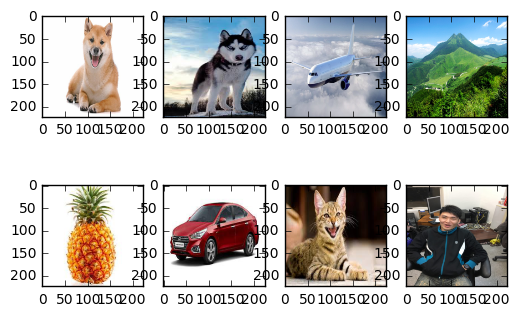

In [191]:
image_datas = []
f, axarr = plt.subplots(2,4)
for i,pred in enumerate(Y_pred):
    print(i+1,". ",flabel_names100[pred])
    y2 = w2model.most_similar(flabel_names100[pred].split("_")[0], topn=10)
    for item in y2:
        print (item[0], item[1],end=' ')
    print('\n')
    new_im = Image.fromarray(new_jpg[i])
    image_datas.append(new_im)
count = 0   
for j in range(2):
    for i in range(4):
        try:
            axarr[j,i].imshow(image_datas[count])
            count = count + 1
        except:
            break



In [163]:
 flabel_names100[58]

'pickup_truck'

In [166]:
y2 = model.most_similar("pickup", topn=10)
for item in y2:
    print (item[0], item[1],end=' ')

truck 0.6509097814559937 pickups 0.6421767473220825 trucks 0.632301926612854 suv 0.5761001110076904 suvs 0.5555229187011719 vans 0.5337337255477905 f-150 0.5319564342498779 vehicle 0.5308193564414978 minivan 0.5199181437492371 vehicles 0.5155760049819946 